In [1]:
import sqlite3 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Introduction
This project is building upon a project I did in college, Empirical Comparison of Binary Classifiers. I have learned so much since finsihing the first iteration of this project and I wanted to apply my new knowledge to perform a deeper dive into classification algortithms. 
<br><br>
In this project I compare three different classification algorithms (Logistic Regression, K-Nearest Neighbors, and Random Forest) on a breast cancer dataset form the UCI repository with the goal of classifying tumors as benign or malignant. For this problem, I chose to use recall/sensitivity as the main performance metric because presenting a false negative has much more serious consequences than presenting a false positive.

# Findings
After tuning hyperparameters, the random forest classifier performed the best on the test set with a sensitivity score of 94.83%. However, I also iterated through different thresholds for the logistic regression classifier and found that lowering the threshold from 0.5 to 0.1 resulted in a sensitivity score of 100% without sacrificing specificity. This finding may be a result of overfitting. 

### Best Model:
Logistic Regression with 0.1 threshold, parameters {C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

# Table of Contents 
1. ### [Loading Data](#step1)
2. ### [EDA and Pre-processing](#step2)
3. ### [Train Test Split](#step3)
4. ### [Model Training](#step4)
5. ### [Confusion Matrix Evaluation](#step5)
6. ### [Parameter Tuning and Re-evaluation](#step6)

# 1. Loading Data <a id='step1'></a>

In [2]:
df = pd.read_csv('breast-cancer-wisconsin.csv', header=None)
df.columns = ['ID', 'Clump Thickness', 'Unif. of Cell Size', 'Unif. of Cell Shape', 
              'Marginal Adhesion', 'Single Epithetlial Cell Size', 'Bare Nuclei', 
              'Bland Chromatin', 'Nomal Nucleoli', 'Mitoses', 'Target']
replace_dict = {2: 0, 4: 1}
df.Target = df.Target.replace(replace_dict)
df

,ID,Clump Thickness,Unif. of Cell Size,Unif. of Cell Shape,Marginal Adhesion,Single Epithetlial Cell Size,Bare Nuclei,Bland Chromatin,Nomal Nucleoli,Mitoses,Target
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,0
695,841769,2,1,1,1,2,1,1,1,1,0
696,888820,5,10,10,3,7,3,8,10,2,1
697,897471,4,8,6,4,3,4,10,6,1,1


# 2. EDA and Pre-processing <a id='step2'></a>
- General Data Ifno
    - 699 records
    - 458 benign (65.5%), 241 malignant (34.5%)
    - All features on 1-10 scale
        - Categorical?
- Null Values
    - Bare Nuclei Feature has 16 instances of null value 
    - Going to drop null values resulting in 683 total records
- Scaling
    - No need for scaling because all features are on the same 1-10 scale

### EDA

In [3]:
df.describe()

,ID,Clump Thickness,Unif. of Cell Size,Unif. of Cell Shape,Marginal Adhesion,Single Epithetlial Cell Size,Bland Chromatin,Nomal Nucleoli,Mitoses,Target
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,0.344778
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.475636
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [4]:
df.Target.value_counts()

0    458
1    241
Name: Target, dtype: int64

In [5]:
df.dtypes

ID                               int64
Clump Thickness                  int64
Unif. of Cell Size               int64
Unif. of Cell Shape              int64
Marginal Adhesion                int64
Single Epithetlial Cell Size     int64
Bare Nuclei                     object
Bland Chromatin                  int64
Nomal Nucleoli                   int64
Mitoses                          int64
Target                           int64
dtype: object

### Preprocessing

In [6]:
np.unique(df['Bare Nuclei'])

array(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', '?'],
      dtype=object)

In [7]:
df['Bare Nuclei'].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare Nuclei, dtype: int64

In [8]:
df = df[df['Bare Nuclei'] != '?']
df['Bare Nuclei'] = df['Bare Nuclei'].apply(pd.to_numeric)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
df

,ID,Clump Thickness,Unif. of Cell Size,Unif. of Cell Shape,Marginal Adhesion,Single Epithetlial Cell Size,Bare Nuclei,Bland Chromatin,Nomal Nucleoli,Mitoses,Target
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,0
695,841769,2,1,1,1,2,1,1,1,1,0
696,888820,5,10,10,3,7,3,8,10,2,1
697,897471,4,8,6,4,3,4,10,6,1,1


# 3. Train Test Split <a id='step3'></a>
- Train set: 546 records
- Test set: 137 records

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['ID', 'Target'], axis=1), df.Target, test_size=0.2, random_state=42 )


# 4. Model Training <a id='step4'></a>

In [11]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [12]:
lr_pred = lr.predict(X_test)

In [13]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [14]:
knn_pred = knn.predict(X_test)

In [15]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
rf_pred = rf.predict(X_test)

# 5. Confusion Matrix Evaluation <a id='step5'></a>
- Since minimizing the proportion of false negatives is paramount in predicting cancer, I will be optimizing for recall/sensitivity. 
- Accuracy is not a good measure because the data set is mostly benign
- Will not use KNN because its intial sensitivity is lower than that of logistic regression and random forest

### Logistic Regression

Sensitivity: 91.38%
Specificity: 98.73%


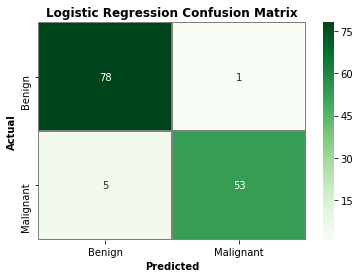

In [17]:
lr_cm = confusion_matrix(y_test, lr_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens', linecolor='gray', 
            linewidths=1, xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Logistic Regression Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')

lr_sens = round(100*lr_cm[1][1]/(lr_cm[1][1]+lr_cm[1][0]), 2)
lr_spec = round(100*lr_cm[0][0]/(lr_cm[0][0]+lr_cm[0][1]),2)
print('Sensitivity: {}%'.format(lr_sens))
print('Specificity: {}%'.format(lr_spec))

Text(0.5, 1.0, 'Logistic Regression ROC Curve')

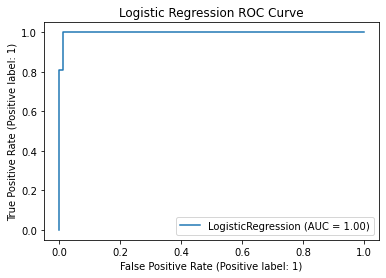

In [18]:
plot_roc_curve(lr, X_test, y_test,)
plt.title('Logistic Regression ROC Curve')

### KNN

Sensitivity: 91.38%
Specificity: 98.73%


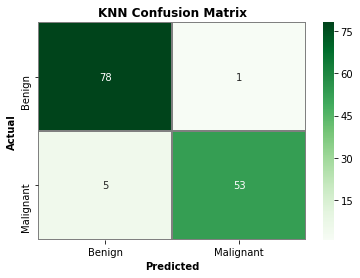

In [19]:
knn_cm = confusion_matrix(y_test, knn_pred)
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Greens', linecolor='gray',
            linewidths=1, xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('KNN Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')

knn_sens = round(100*knn_cm[1][1]/(knn_cm[1][1]+knn_cm[1][0]), 2)
knn_spec = round(100*knn_cm[0][0]/(knn_cm[0][0]+knn_cm[0][1]),2)
print('Sensitivity: {}%'.format(knn_sens))
print('Specificity: {}%'.format(knn_spec))

Text(0.5, 1.0, 'KNN ROC Curve')

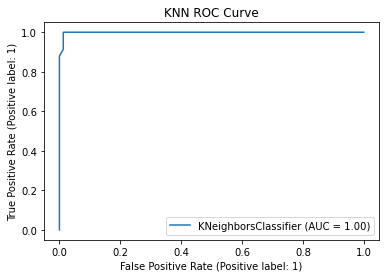

In [20]:
plot_roc_curve(knn, X_test, y_test,)
plt.title('KNN ROC Curve')

### Random Forest

Sensitivity: 91.38%
Specificity: 98.73%


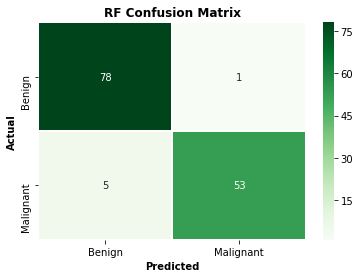

In [21]:
rf_cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', 
            linewidths=1, xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('RF Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')

rf_sens = round(100*rf_cm[1][1]/(rf_cm[1][1]+rf_cm[1][0]), 2)
rf_spec = round(100*rf_cm[0][0]/(rf_cm[0][0]+rf_cm[0][1]),2)
print('Sensitivity: {}%'.format(rf_sens))
print('Specificity: {}%'.format(rf_spec))

Text(0.5, 1.0, 'Random Forest ROC Curve')

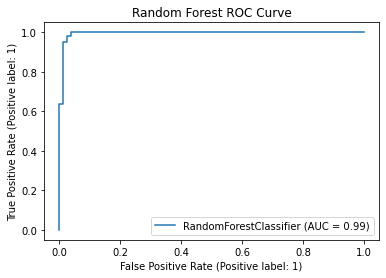

In [22]:
plot_roc_curve(rf, X_test, y_test,)
plt.title('Random Forest ROC Curve')

# 6. Parameter Tuning and Re-evaluation <a id='step6'></a>
- Using Grid Search for parameter tuning and cross validation to avoid over fitting
- Use F1 as logistic regression scorer because when recall is used, predicts all cases as positive

### Logistic Regression

In [23]:
lr_pg = {
    'C': [10**(-8),10**(-7),10**(-6),10**(-5),10**(-4),10**(-3),10**(-2),10**(-1), 1, 10, 100, 1000, 10000],
    'penalty': ['l2', 'none'],
    'solver':['lbfgs', 'liblinear']
}

lr_gs = GridSearchCV(lr, param_grid=lr_pg, scoring='f1', cv=5)
lr_gs.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError:

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10, 100, 1000, 10000],
                         'penalty': ['l2', 'none'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='f1')

In [24]:
best_lr = lr_gs.best_estimator_
best_lr.fit(X_train, y_train)
lr_ypred = best_lr.predict(X_test)

Sensitivity: 91.38%
Specificity: 98.73%


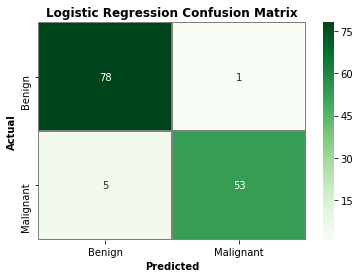

In [25]:
lr_cm2 = confusion_matrix(y_test, lr_ypred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens', linecolor='gray', 
            linewidths=1, xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Logistic Regression Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')

lr_sens2 = round(100*lr_cm2[1][1]/(lr_cm2[1][1]+lr_cm2[1][0]), 2)
lr_spec2 = round(100*lr_cm2[0][0]/(lr_cm2[0][0]+lr_cm2[0][1]),2)
print('Sensitivity: {}%'.format(lr_sens))
print('Specificity: {}%'.format(lr_spec))

Text(0.5, 1.0, 'Logistic Regression ROC Curve')

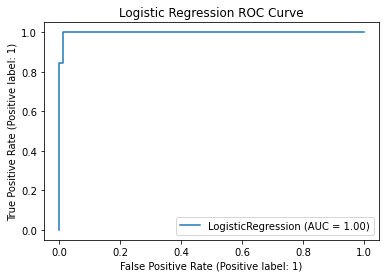

In [26]:
plot_roc_curve(best_lr, X_test, y_test,)
plt.title('Logistic Regression ROC Curve')

### KNN

In [38]:
k = np.linspace(1, 5000, num=26, dtype=int, endpoint=False)
knn_pg = {
    'n_neighbors':k,
    'weights': ['distance', 'uniform']
}
knn_gs = GridSearchCV(knn, param_grid=knn_pg, scoring='recall', cv=5)
knn_gs.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbor

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbor

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbor

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbor

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbor

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbor

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=7),
             param_grid={'n_neighbors': array([   1,  193,  385,  577,  770,  962, 1154, 1346, 1539, 1731, 1923,
       2115, 2308, 2500, 2692, 2885, 3077, 3269, 3461, 3654, 3846, 4038,
       4230, 4423, 4615, 4807]),
                         'weights': ['distance', 'uniform']},
             scoring='recall')

In [39]:
best_knn = knn_gs.best_estimator_
best_knn.fit(X_train, y_train)
knn_ypred = best_knn.predict(X_test)

Sensitivity: 87.93%
Specificity: 98.73%


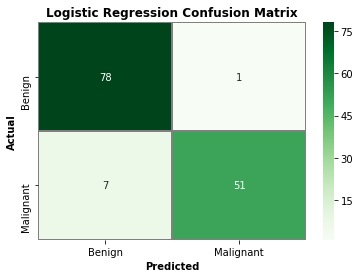

In [40]:
knn_cm2 = confusion_matrix(y_test, knn_ypred)
sns.heatmap(knn_cm2, annot=True, fmt='d', cmap='Greens', linecolor='gray', 
            linewidths=1, xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Logistic Regression Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')

knn_sens2 = round(100*knn_cm2[1][1]/(knn_cm2[1][1]+knn_cm2[1][0]), 2)
knn_spec2 = round(100*knn_cm2[0][0]/(knn_cm2[0][0]+knn_cm2[0][1]),2)
print('Sensitivity: {}%'.format(knn_sens2))
print('Specificity: {}%'.format(knn_spec2))

### Random Forest

In [27]:
rf_pg = {
    'n_estimators': [1024], 
    'max_features': [1,2,4,6,8,12,16,20]

}
rf_gs = GridSearchCV(rf, param_grid=rf_pg, scoring='recall', cv=5)
rf_gs.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/p

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/p

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/p

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/p

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': [1, 2, 4, 6, 8, 12, 16, 20],
                         'n_estimators': [1024]},
             scoring='recall')

In [28]:
rf_gs.best_params_

{'max_features': 1, 'n_estimators': 1024}

In [29]:
best_rf = rf_gs.best_estimator_
best_rf.fit(X_train, y_train)
rf_ypred = best_rf.predict(X_test)

Sensitivity: 94.83%
Specificity: 98.73%


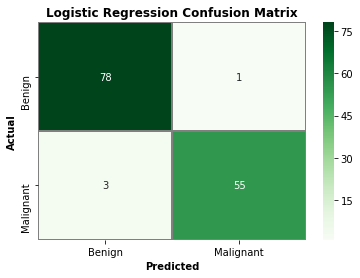

In [30]:
rf_cm2 = confusion_matrix(y_test, rf_ypred)
sns.heatmap(rf_cm2, annot=True, fmt='d', cmap='Greens', linecolor='gray', 
            linewidths=1, xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Logistic Regression Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')

rf_sens2 = round(100*rf_cm2[1][1]/(rf_cm2[1][1]+rf_cm2[1][0]), 2)
rf_spec2 = round(100*rf_cm2[0][0]/(rf_cm2[0][0]+rf_cm2[0][1]),2)
print('Sensitivity: {}%'.format(rf_sens2))
print('Specificity: {}%'.format(rf_spec2))

Text(0.5, 1.0, 'Random Forest ROC Curve')

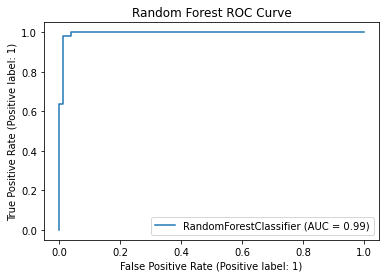

In [31]:
plot_roc_curve(best_rf, X_test, y_test,)
plt.title('Random Forest ROC Curve')

### Testing Different LR Thresholds
- Want to lower the threshold in order to decrease the number of false negatives because these are more dangerous than the false positive errors
- See that by lowering the threshold we are able to eliminate false negatives and maintain the same level of false positives as the default 0.5 threshold

In [41]:
lr_prob = best_lr.predict_proba(X_test)

In [42]:
vals = np.linspace(1, 9, num=9)/10
pred_dict = dict()
for i in vals:
    pred_dict[i] = []
    y_test_pred = []
    for j in lr_prob:
        if j[1] > i:
            y_test_pred.append(1)
        else:
            y_test_pred.append(0)
    pred_dict[i] = y_test_pred

In [43]:
pred_dict.keys()

dict_keys([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [44]:
for i in pred_dict:
    cm = confusion_matrix(y_test, pred_dict[i])
    print(i)
    print(cm)

0.1
[[78  1]
 [ 0 58]]
0.2
[[78  1]
 [ 1 57]]
0.3
[[78  1]
 [ 2 56]]
0.4
[[78  1]
 [ 4 54]]
0.5
[[78  1]
 [ 4 54]]
0.6
[[78  1]
 [ 8 50]]
0.7
[[78  1]
 [ 9 49]]
0.8
[[79  0]
 [10 48]]
0.9
[[79  0]
 [17 41]]


Sensitivity: 100.0%
Specificity: 98.73%


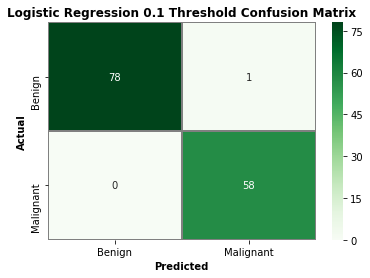

In [45]:
cm = confusion_matrix(y_test, pred_dict[0.1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', linecolor='gray', 
            linewidths=1, xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Logistic Regression 0.1 Threshold Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')

sens = round(100*cm[1][1]/(cm[1][1]+cm[1][0]),2)
spec = round(100*cm[0][0]/(cm[0][0]+cm[0][1]),2)
print('Sensitivity: {}%'.format(sens))
print('Specificity: {}%'.format(spec))

In [50]:
lr_gs.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}